# Red Neuronal para discriminacion de Gamma/Neutron

Se creara una red neuronal que discrimine entre Gamma y Neutrones a partir de sus trazas de evento, esto a traves de Machine Learning implementado en la FPGA

---

## Entrenamiento
Este entrenamiento se realizará basado en el trabajo previo:
- Workflow based on R. S. Molina, I. R. Morales, M. L. Crespo, V. G. Costa, S. Carrato and G. Ramponi, "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA", in IEEE Embedded Systems Letters, vol. 16, no. 3, pp. 255-258, Sept. 2024, doi: 10.1109/LES.2023.3343030.
- Code adapted from the official repository of "An End-to-End Workflow to Efficiently Compress and Deploy DNN Classifiers on SoC/FPGA"
- Using open dataset from: https://doi.org/10.5281/zenodo.8037058


### Importación de librerias

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Tensorflow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2, l1

import tensorflow_model_optimization as tfmot

# Pruning API
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_schedule, pruning_callbacks
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# Quantization API
from qkeras import *

# Knowledge Distillation
from src.distillationClassKeras import *

# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# Pre-processing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Training utils
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)
np.random.seed(42)


Evaluamos el numero de GPUs disponibles para entrenamiento

In [2]:
# import tensorflow as tf 
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(physical_devices))
print("Available devices: ", physical_devices)

# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  0
Available devices:  []


In [3]:
# Function to define the training and testing datasets

def preproc_dataset_(signal_dfN, signal_dfG):
    # data for Neutrons and Gammas
    # Label in csv file corresponds to the signal class (0: gamma, 1: neutron)
    _LABEL_COLUMN = 'class' 

    dfTest  = pd.DataFrame()
    dfTrain = pd.DataFrame()

    signal_dfN = shuffle(signal_dfN)
    signal_dfG = shuffle(signal_dfG)

    signal_df = pd.concat([signal_dfN, signal_dfG])

    for k in range(0,2):
        df2 = signal_df[signal_df[_LABEL_COLUMN].isin([k])]

        df_tr = df2[:10000]
        df_t  = df2[10001:10900]

        dfTrain = pd.concat([df_tr, dfTrain])
        dfTest  = pd.concat([df_t, dfTest])

    return dfTrain, dfTest


In [4]:
# Define paths to datasets

PATH = 'dataset/'

GAMMA_DATASET_FILE   = PATH + 'gamma_label.csv'
NEUTRON_DATASET_FILE = PATH + 'neutron_label.csv'

TEST_DATASET_FILE  = PATH + 'test.csv'

# Load datasets
dfGamma   = pd.read_csv(GAMMA_DATASET_FILE)
dfNeutron = pd.read_csv(NEUTRON_DATASET_FILE)
dfTestGN  = pd.read_csv(TEST_DATASET_FILE)

### Preprocesamiento y separacion de dataset

Separacion del dataset en datos de entrenamiento y de test

In [5]:
# Pre-processing dataset for training
df_train, dfTest = preproc_dataset_(dfNeutron, dfGamma)

# Save the test
# dfTest.to_csv('dataset/test.csv')

df_train_ = df_train.pop('class')
dfTest_   = dfTest.pop('class')

# One-hot encoder
le = LabelEncoder()
y = le.fit_transform(df_train_)
y = to_categorical(df_train_, 2)

le = LabelEncoder()
yTest = le.fit_transform(dfTest_)
yTest = to_categorical(dfTest_, 2)

# Split training dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(df_train, y, test_size=0.3, random_state=42)


## Carga del modelo

Aqui se carga el modelo y los datos de entrenamiento

In [6]:
teacher_model = keras.models.load_model("models/teacherModel_GN_GICM.h5")
teacher_model.summary()

Model: "teacher_MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 10)                1620      
                                                                 
 relu1 (Activation)          (None, 10)                0         
                                                                 
 fc2 (Dense)                 (None, 5)                 55        
                                                                 
 relu2 (Activation)          (None, 5)                 0         
                                                                 
 fc3 (Dense)                 (None, 7)                 42        
                                                                 
 relu3 (Activation)          (None, 7)                 0         
                                                                 
 dropout (Dropout)           (None, 7)                 

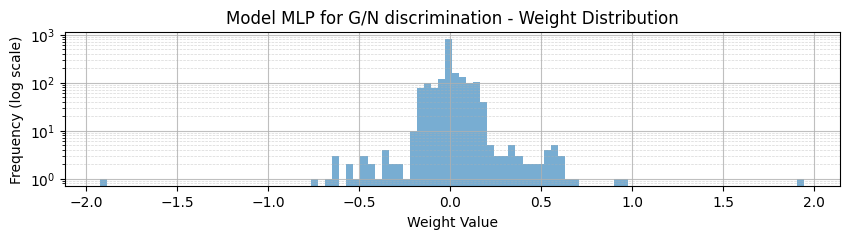

In [7]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])

plt.figure(figsize=(10,2))
plt.hist(weights, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution")

# Escala logarítmica en el eje Y
plt.yscale("log")

# Grid principal -> línea continua
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)

# Grid secundario -> línea punteada y tenue
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)

plt.show()

57/57 [==============================] - 0s 778us/step


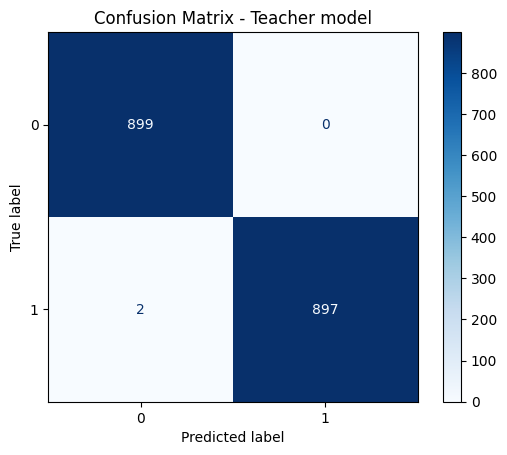

In [8]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = teacher_model.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
#plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix - Teacher model')
plt.show()

### Podado, Pruning

Aqui se hara el proceso de podado y reduccion de complejidad del modelo para el modelo entrenado. Primero se cargara el modelo previamente guardado

In [9]:
epochs = 32
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 32
val_split = 0.2

final_sparsity = 0.3 # percentage of weights pruned

pruning_params = {
                 'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                    initial_sparsity=0, 
                    final_sparsity=final_sparsity, 
                    begin_step=0, 
                    end_step=1000
                 )
                 }

In [10]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     patience=2,
    #     verbose=1,
    #     restore_best_weights=True
    # ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', #'val_loss',
        factor=0.4,
        patience=3,
        verbose=1
    ), 
    pruning_callbacks.UpdatePruningStep()
]

### Podado del modelo

In [11]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(teacher_model, **pruning_params)
modelP.compile(optimizer=op, loss=loss, metrics=metrics)

In [12]:
history_P = modelP.fit(x=x_train, y=y_train,
                       validation_split=val_split,
                       batch_size=64, 
                       epochs=32,
                       callbacks= [callbacks],
                       verbose=1
                       )

Epoch 1/32
175/175 [==============================] - 3s 3ms/step - loss: 1.0310 - accuracy: 0.6831 - val_loss: 0.0490 - val_accuracy: 0.9961 - lr: 0.0010
Epoch 2/32
175/175 [==============================] - 0s 1ms/step - loss: 0.1741 - accuracy: 0.9513 - val_loss: 0.0480 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 3/32
175/175 [==============================] - 0s 2ms/step - loss: 0.1778 - accuracy: 0.9547 - val_loss: 0.0506 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 4/32
175/175 [==============================] - 0s 1ms/step - loss: 0.1675 - accuracy: 0.9590 - val_loss: 0.0531 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 5/32
171/175 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9593
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
175/175 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.9587 - val_loss: 0.0548 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 6/32
175/175 [==============================] - 0s 1ms/ste

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


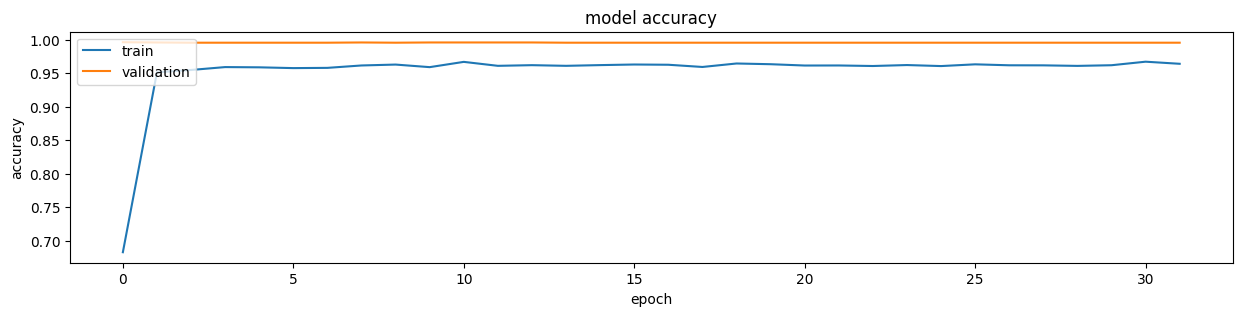

<Figure size 640x480 with 0 Axes>

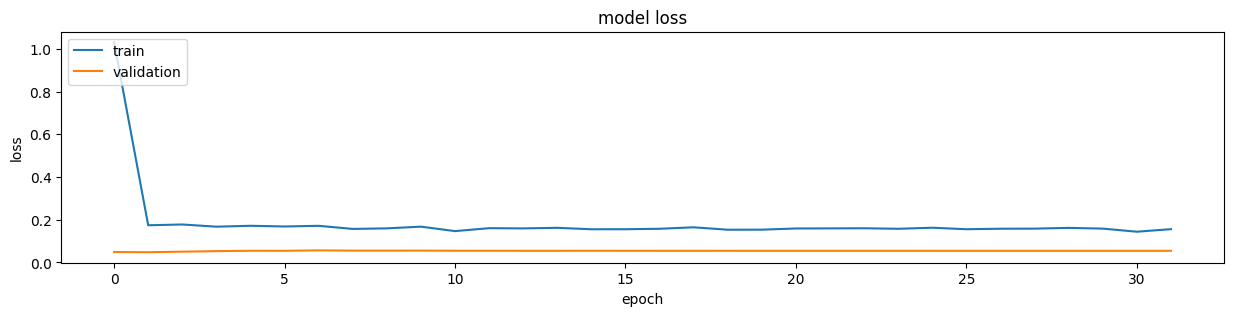

In [13]:
print(history_P.history.keys())

## Plot for accuracy
plt.figure(figsize=(15,3))
plt.plot(history_P.history['accuracy'])
plt.plot(history_P.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.figure()

## Plot for loss
plt.figure(figsize=(15,3))
plt.plot(history_P.history['loss'])
plt.plot(history_P.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

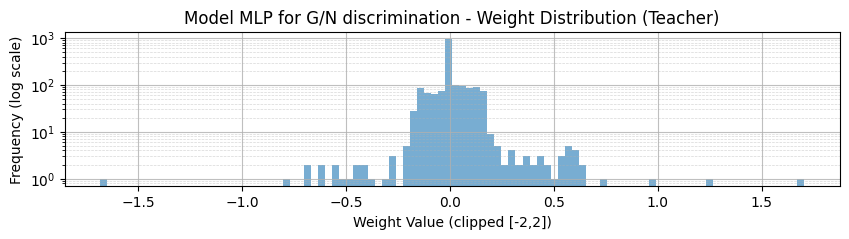

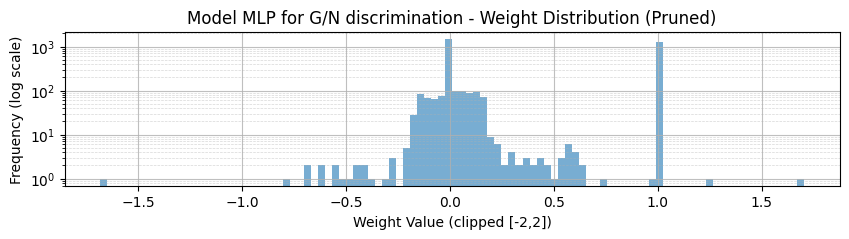

In [14]:
# Weight distribution

weights = np.concatenate([w.flatten() for w in teacher_model.get_weights()])
weights_p = np.concatenate([w.flatten() for w in modelP.get_weights()])

# Filtrar pesos entre -2 y 2
weights_clip  = weights[(weights >= -2) & (weights <= 2)]
weights_p_clip = weights_p[(weights_p >= -2) & (weights_p <= 2)]

# Histograma del modelo original
plt.figure(figsize=(10,2))
plt.hist(weights_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Teacher)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

# Histograma del modelo podado
plt.figure(figsize=(10,2))
plt.hist(weights_p_clip, bins=100, color='tab:blue', alpha=0.6)
plt.xlabel("Weight Value (clipped [-2,2])")
plt.ylabel("Frequency (log scale)")
plt.title("Model MLP for G/N discrimination - Weight Distribution (Pruned)")
plt.yscale("log")
plt.grid(which="major", linestyle="-", linewidth=0.8, alpha=0.8)
plt.grid(which="minor", linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()


### Confusion matrix

Matriz de confusion despues del podado

57/57 [==============================] - 0s 771us/step


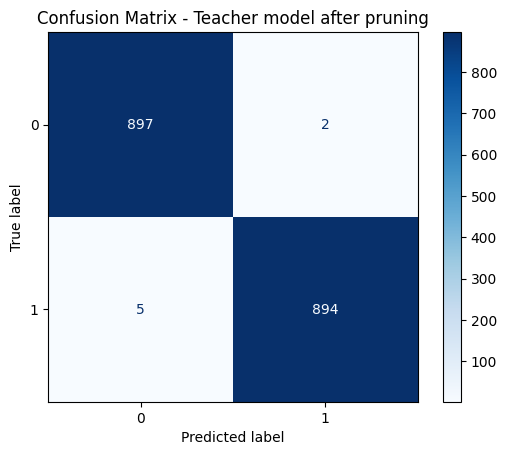

In [15]:
# Obtain the confusion matrix using the testing dataset 
y_pred_probs = modelP.predict(dfTest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(yTest, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix - Teacher model after pruning')
plt.show()

---

## Cuantizacion (QAT)

Aqui se aplicara la cuantizacion para reducir el tamaño y resolucion de la red

In [ ]:
## Estrategia de cuantizacion

## Definicion del numero de bits para kernel, bias, y activacion.
# 8-bits





---
**Autor**: Fabian Castaño